<a href="https://colab.research.google.com/github/aqeebakeel/Weather-Forecasting-Risk-Propagation/blob/main/Graph_AI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas matplotlib seaborn networkx scipy tensorflow keras shapely opencv-python geopy

In [ ]:
pip install meteostat pandas

In [ ]:
from meteostat import Stations, Hourly
from datetime import datetime, timedelta
import pandas as pd
import os

def get_historical_weather(city, start_date, end_date, filename="chennai_weather.csv"):
    # Fetch the nearest weather station to the given city
    stations = Stations().nearby(13.0827, 80.2707)  # Chennai coordinates (lat, lon)
    station = stations.fetch(1)  # Get the closest station

    if station.empty:
        print("No weather stations found nearby.")
        return None

    station_id = station.index[0]  # Get station ID

    # Get hourly weather data for the given date range
    weather_data = Hourly(station_id, start_date, end_date).fetch()

    if weather_data.empty:
        print("No weather data available.")
        return None

    # Reset index for proper CSV formatting
    weather_data.reset_index(inplace=True)

    # Check if the file exists
    file_exists = os.path.isfile(filename)

    # Save data to CSV (append mode if file exists)
    weather_data.to_csv(filename, mode='a', header=not file_exists, index=False)
    print(f"Weather data from {start_date} to {end_date} saved to {filename}")

# Define time range (last 2 years)
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=730)  # 2 years of data

# Fetch & save historical weather data
get_historical_weather("Chennai", start_date, end_date)

Weather data from 2023-09-24 09:35:57.246622 to 2025-09-23 09:35:57.246622 saved to chennai_weather.csv


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("chennai_weather.csv")

# Display first few rows
df.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2023-09-24 10:00:00,30.2,25.3,75.0,0.1,NaN,138.0,14.8,NaN,1004.9,NaN,17.0
1,2023-09-24 11:00:00,29.6,25.1,77.0,0.0,NaN,143.0,17.3,NaN,1004.4,NaN,1.0
2,2023-09-24 12:00:00,30.8,25.6,74.0,0.0,NaN,110.0,9.4,NaN,1005.2,NaN,1.0
3,2023-09-24 13:00:00,28.7,26.5,88.0,0.0,NaN,163.0,16.2,NaN,1006.0,NaN,3.0
4,2023-09-24 14:00:00,28.3,26.3,89.0,0.0,NaN,168.0,14.8,NaN,1007.0,NaN,3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select the feature for prediction (e.g., temperature)
data = df[['temp']].values  # Selecting temperature column

# Normalize the data (scale values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define function to create time series dataset
def create_sequences(data, time_steps=24):  # 24-hour window
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences for LSTM
time_steps = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(data_scaled, time_steps)

# Split into train & test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer (temperature prediction)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


426/426 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.0277 - val_loss: 0.0045
Epoch 2/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 3/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 4/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 5/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 6/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 7/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 8/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 9/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 11/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 12/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


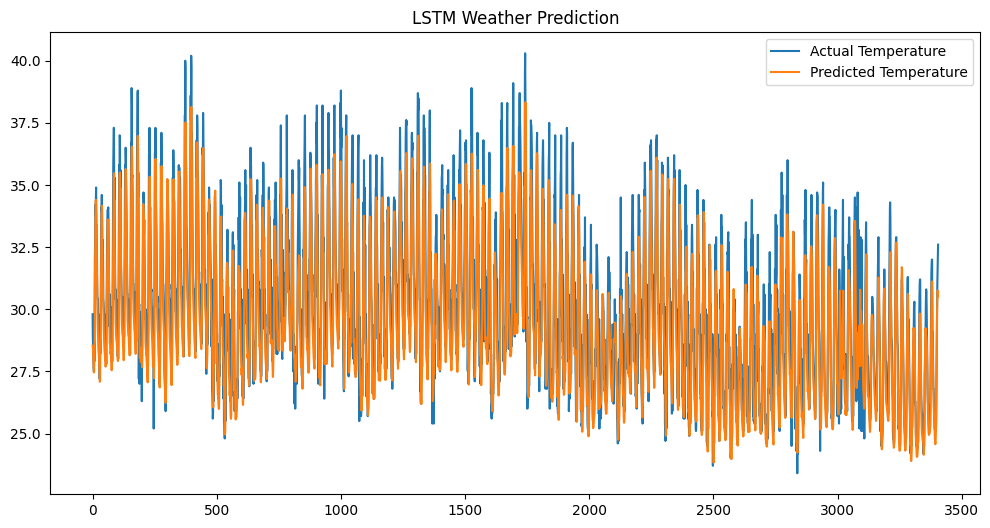

In [ ]:
import matplotlib.pyplot as plt

# Predict on test data
predictions = model.predict(X_test)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Temperature")
plt.plot(predictions, label="Predicted Temperature")
plt.legend()
plt.title("LSTM Weather Prediction")
plt.show()

In [ ]:
def predict_future(temp_data):
    temp_data_scaled = scaler.transform(np.array(temp_data).reshape(-1, 1))
    temp_sequence = np.reshape(temp_data_scaled[-time_steps:], (1, time_steps, 1))
    prediction = model.predict(temp_sequence)
    return scaler.inverse_transform(prediction)[0][0]

# Example: Predict next hour's temperature
latest_temp_data = data[-time_steps:]  # Last 24 hours' data
predicted_temp = predict_future(latest_temp_data)
print(f"Predicted Temperature for next hour: {predicted_temp:.2f}°C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Temperature for next hour: 30.29°C


In [ ]:
!pip install networkx matplotlib

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define a sample set of neighborhoods in Chennai (mostly coastal)
areas = {
    "Marina Beach": {"temp": 32, "humidity": 80, "wind_speed": 18, "risk": 0.9},
    "Besant Nagar": {"temp": 31, "humidity": 78, "wind_speed": 17, "risk": 0.85},
    "Thiruvanmiyur": {"temp": 30, "humidity": 75, "wind_speed": 15, "risk": 0.7},
    "Adyar": {"temp": 31, "humidity": 74, "wind_speed": 12, "risk": 0.65},
    "Mylapore": {"temp": 32, "humidity": 76, "wind_speed": 13, "risk": 0.7},
    "Santhome": {"temp": 32, "humidity": 79, "wind_speed": 14, "risk": 0.8},
    "T. Nagar": {"temp": 33, "humidity": 70, "wind_speed": 10, "risk": 0.6},
    "Velachery": {"temp": 30, "humidity": 72, "wind_speed": 11, "risk": 0.5},
    "Perungudi": {"temp": 29, "humidity": 73, "wind_speed": 12, "risk": 0.55},
    "Sholinganallur": {"temp": 28, "humidity": 75, "wind_speed": 14, "risk": 0.6}
}

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for area, data in areas.items():
    G.add_node(area, temp=data["temp"], humidity=data["humidity"], wind_speed=data["wind_speed"], risk=data["risk"])

# Define connections between coastal neighborhoods
edges = [
    ("Marina Beach", "Santhome"),
    ("Santhome", "Mylapore"),
    ("Mylapore", "Adyar"),
    ("Adyar", "Besant Nagar"),
    ("Besant Nagar", "Thiruvanmiyur"),
    ("Thiruvanmiyur", "Velachery"),
    ("Velachery", "Perungudi"),
    ("Perungudi", "Sholinganallur"),
    ("Besant Nagar", "Marina Beach"),
    ("Thiruvanmiyur", "Adyar"),
    ("Mylapore", "T. Nagar"),
    ("T. Nagar", "Velachery")
]

# Add weighted edges (risk propagation based on temperature, wind speed, and humidity)
for edge in edges:
    area1, area2 = edge
    weight = (abs(areas[area1]["temp"] - areas[area2]["temp"]) +
              abs(areas[area1]["wind_speed"] - areas[area2]["wind_speed"]) +
              abs(areas[area1]["humidity"] - areas[area2]["humidity"]) / 10)  # Normalize humidity factor
    G.add_edge(area1, area2, weight=weight)

# Display the graph structure
print("Graph Nodes:", G.nodes(data=True))
print("Graph Edges:", G.edges(data=True))

Graph Nodes: [('Marina Beach', {'temp': 32, 'humidity': 80, 'wind_speed': 18, 'risk': 0.9}), ('Besant Nagar', {'temp': 31, 'humidity': 78, 'wind_speed': 17, 'risk': 0.85}), ('Thiruvanmiyur', {'temp': 30, 'humidity': 75, 'wind_speed': 15, 'risk': 0.7}), ('Adyar', {'temp': 31, 'humidity': 74, 'wind_speed': 12, 'risk': 0.65}), ('Mylapore', {'temp': 32, 'humidity': 76, 'wind_speed': 13, 'risk': 0.7}), ('Santhome', {'temp': 32, 'humidity': 79, 'wind_speed': 14, 'risk': 0.8}), ('T. Nagar', {'temp': 33, 'humidity': 70, 'wind_speed': 10, 'risk': 0.6}), ('Velachery', {'temp': 30, 'humidity': 72, 'wind_speed': 11, 'risk': 0.5}), ('Perungudi', {'temp': 29, 'humidity': 73, 'wind_speed': 12, 'risk': 0.55}), ('Sholinganallur', {'temp': 28, 'humidity': 75, 'wind_speed': 14, 'risk': 0.6})]
Graph Edges: [('Marina Beach', 'Santhome', {'weight': 4.1}), ('Marina Beach', 'Besant Nagar', {'weight': 2.2}), ('Besant Nagar', 'Adyar', {'weight': 5.4}), ('Besant Nagar', 'Thiruvanmiyur', {'weight': 3.3}), ('Thiru

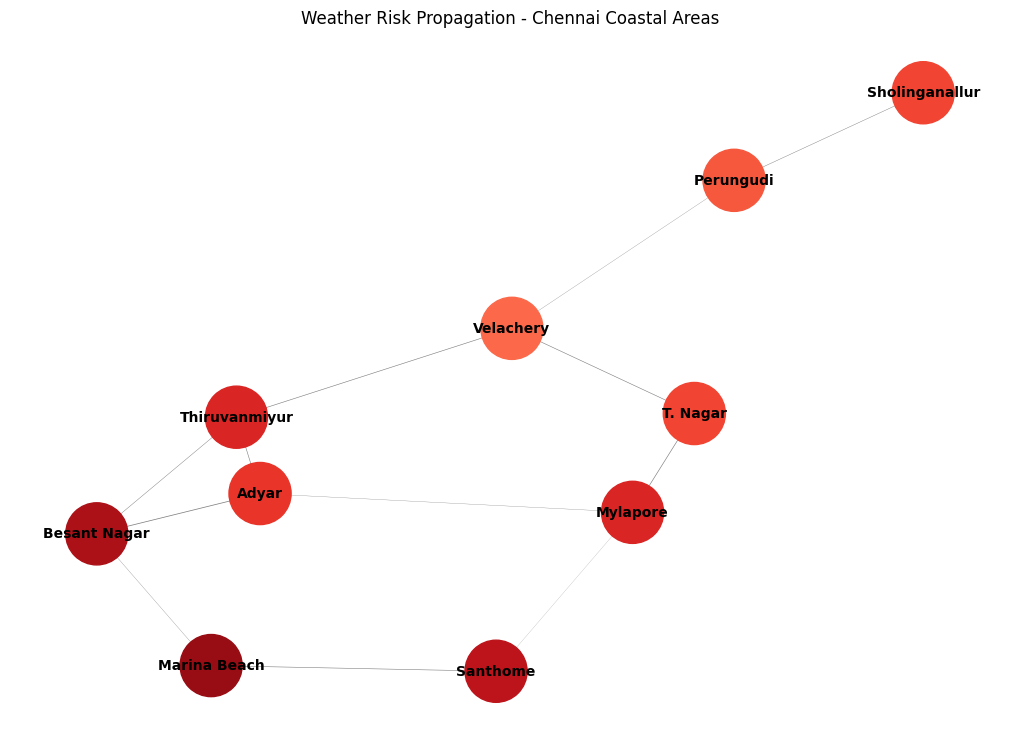

In [ ]:
# Get risk values for coloring
risk_values = [data["risk"] for area, data in G.nodes(data=True)]

# Define a colormap based on risk levels
node_colors = [plt.cm.Reds(risk) for risk in risk_values]

# Get edge weights for thickness
edge_weights = [G[u][v]['weight'] / 10 for u, v in G.edges()]  # Normalize edge thickness

# Draw the graph
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)  # Positioning nodes

nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, edge_color='gray', width=edge_weights, font_size=10, font_weight='bold')

plt.title("Weather Risk Propagation - Chennai Coastal Areas")
plt.show()

In [ ]:
def propagate_risk(G, iterations=5, decay_factor=0.75):
    """
    Simulates risk propagation across regions over time.
    - iterations: Number of steps to simulate.
    - decay_factor: Controls how quickly risk spreads (0.0 to 1.0).
    """
    for step in range(iterations):
        new_risk = {}
        for node in G.nodes():
            risk_sum = sum(G.nodes[neighbor]["risk"] * decay_factor for neighbor in G.neighbors(node))
            new_risk[node] = min(1.0, risk_sum / max(1, len(list(G.neighbors(node)))))  # Normalize

        # Update risk values
        for node in G.nodes():
            G.nodes[node]["risk"] = new_risk[node]

        print(f"Iteration {step+1}: Risk Levels -", {node: round(G.nodes[node]["risk"], 2) for node in G.nodes()})

# Run risk propagation simulation
propagate_risk(G)

Iteration 1: Risk Levels - {'Marina Beach': 0.62, 'Besant Nagar': 0.56, 'Thiruvanmiyur': 0.5, 'Adyar': 0.56, 'Mylapore': 0.51, 'Santhome': 0.6, 'T. Nagar': 0.45, 'Velachery': 0.46, 'Perungudi': 0.41, 'Sholinganallur': 0.41}
Iteration 2: Risk Levels - {'Marina Beach': 0.44, 'Besant Nagar': 0.42, 'Thiruvanmiyur': 0.4, 'Adyar': 0.39, 'Mylapore': 0.4, 'Santhome': 0.42, 'T. Nagar': 0.37, 'Velachery': 0.34, 'Perungudi': 0.33, 'Sholinganallur': 0.31}
Iteration 3: Risk Levels - {'Marina Beach': 0.32, 'Besant Nagar': 0.31, 'Thiruvanmiyur': 0.29, 'Adyar': 0.31, 'Mylapore': 0.3, 'Santhome': 0.31, 'T. Nagar': 0.28, 'Velachery': 0.27, 'Perungudi': 0.24, 'Sholinganallur': 0.25}
Iteration 4: Risk Levels - {'Marina Beach': 0.23, 'Besant Nagar': 0.23, 'Thiruvanmiyur': 0.22, 'Adyar': 0.22, 'Mylapore': 0.22, 'Santhome': 0.23, 'T. Nagar': 0.21, 'Velachery': 0.2, 'Perungudi': 0.19, 'Sholinganallur': 0.18}
Iteration 5: Risk Levels - {'Marina Beach': 0.17, 'Besant Nagar': 0.17, 'Thiruvanmiyur': 0.16, 'Adyar'

In [ ]:
# Dictionary with lat-long coordinates for each coastal area in Chennai
location_coords = {
    "Marina Beach": (13.0500, 80.2824),
    "Besant Nagar": (13.0007, 80.2667),
    "Thiruvanmiyur": (12.9847, 80.2599),
    "Adyar": (13.0067, 80.2565),
    "Mylapore": (13.0330, 80.2684),
    "Santhome": (13.0311, 80.2761),
    "T. Nagar": (13.0418, 80.2337),
    "Velachery": (12.9815, 80.2180),
    "Perungudi": (12.9623, 80.2433),
    "Sholinganallur": (12.9091, 80.2270)
}

# Extract the affected area points
affected_points = list(location_coords.values())

print("Affected Area Coordinates:", affected_points)

Affected Area Coordinates: [(13.05, 80.2824), (13.0007, 80.2667), (12.9847, 80.2599), (13.0067, 80.2565), (13.033, 80.2684), (13.0311, 80.2761), (13.0418, 80.2337), (12.9815, 80.218), (12.9623, 80.2433), (12.9091, 80.227)]


In [ ]:
from shapely.geometry import MultiPoint

# Compute convex hull (smallest enclosing boundary of affected areas)
hull = MultiPoint(affected_points).convex_hull

print("Convex Hull Boundary:", hull)

Convex Hull Boundary: POLYGON ((12.9815 80.218, 12.9091 80.227, 12.9847 80.2599, 13.0007 80.2667, 13.05 80.2824, 13.0418 80.2337, 12.9815 80.218))


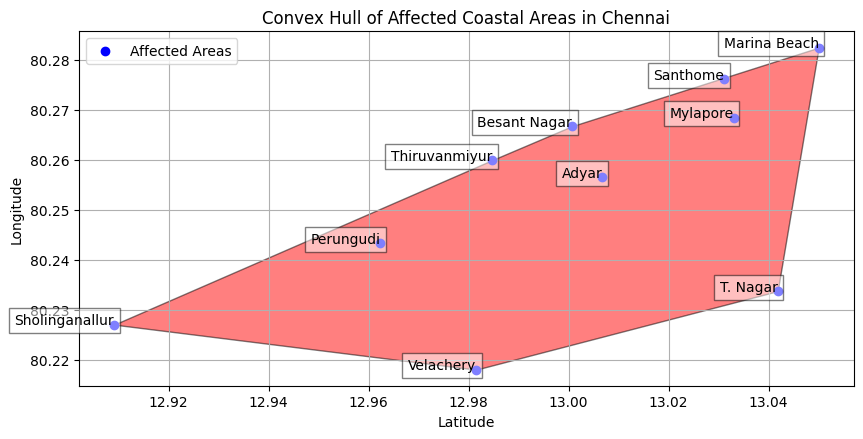

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Convert hull to a GeoDataFrame for visualization
gdf = gpd.GeoDataFrame({'geometry': [hull]})

# Plot the Convex Hull
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color="red", alpha=0.5, edgecolor="black")

# Add affected points to the plot
x, y = zip(*affected_points)
ax.scatter(x, y, color="blue", label="Affected Areas", zorder=2)

# Annotate each point with the area name
for area, (lat, lon) in location_coords.items():
    ax.text(lat, lon, area, fontsize=10, ha='right', color="black", bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.title("Convex Hull of Affected Coastal Areas in Chennai")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def update_risk_zones(new_affected_points):
    """
    Function to update the risk zone dynamically when new affected points are added.
    """
    global hull  # Update global convex hull boundary
    hull = MultiPoint(new_affected_points).convex_hull
    print("Updated Convex Hull Boundary:", hull)

# Example: If new areas get affected
new_affected_points = affected_points + [(12.8900, 80.2200), (13.0600, 80.2900)]
update_risk_zones(new_affected_points)

Updated Convex Hull Boundary: POLYGON ((12.9815 80.218, 12.89 80.22, 13.0007 80.2667, 13.06 80.29, 13.0418 80.2337, 12.9815 80.218))


In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges with capacities (Water Flow Capacity in m³/s)
G.add_edge("Source", "Marina Beach", capacity=50)
G.add_edge("Source", "Adyar River", capacity=40)
G.add_edge("Adyar River", "Marina Beach", capacity=20)
G.add_edge("Adyar River", "Mylapore", capacity=30)
G.add_edge("Marina Beach", "Mylapore", capacity=25)
G.add_edge("Mylapore", "T. Nagar", capacity=35)
G.add_edge("Mylapore", "Kodambakkam", capacity=15)
G.add_edge("T. Nagar", "Sink", capacity=40)
G.add_edge("Kodambakkam", "Sink", capacity=20)

# Compute max flow
flow_value, flow_dict = nx.maximum_flow(G, "Source", "Sink")

# Print Results
print("Maximum Water Flow Capacity:", flow_value)
print("Flow Distribution:", flow_dict)

Maximum Water Flow Capacity: 50
Flow Distribution: {'Source': {'Marina Beach': 20, 'Adyar River': 30}, 'Marina Beach': {'Mylapore': 20}, 'Adyar River': {'Marina Beach': 0, 'Mylapore': 30}, 'Mylapore': {'T. Nagar': 35, 'Kodambakkam': 15}, 'T. Nagar': {'Sink': 35}, 'Kodambakkam': {'Sink': 15}, 'Sink': {}}


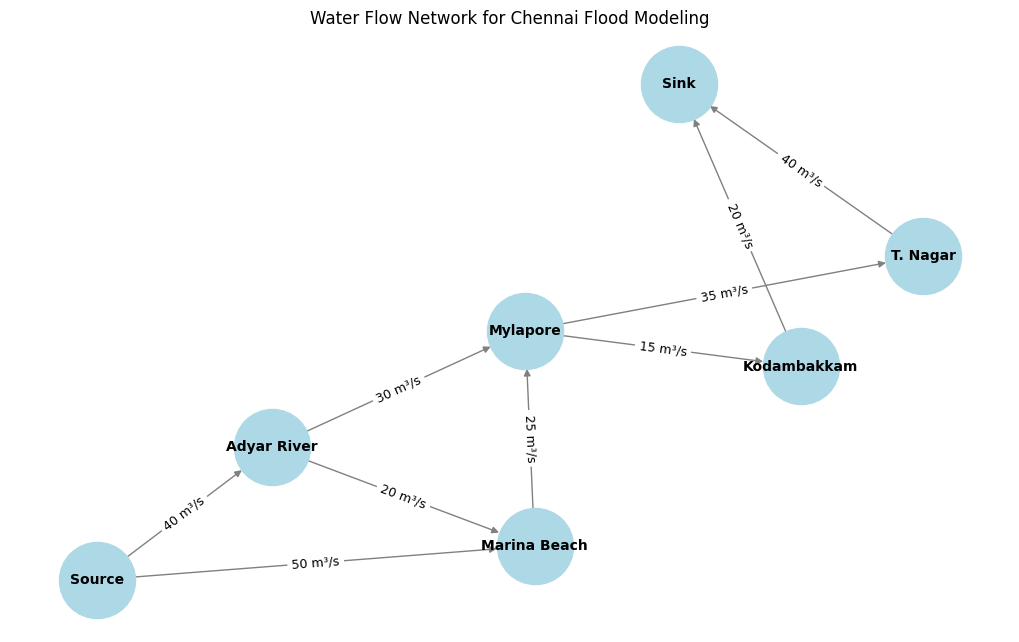

In [ ]:
import matplotlib.pyplot as plt

# Draw the flow network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10, font_weight="bold")

# Draw edge labels (capacity values)
edge_labels = {(u, v): f"{d['capacity']} m³/s" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Water Flow Network for Chennai Flood Modeling")
plt.show()


🔹 Maximum Water Flow Capacity: 50

🔹 Flow Distribution Across Regions:
   Source → Marina Beach: 20 m³/s
   Source → Adyar River: 30 m³/s
   Marina Beach → Mylapore: 20 m³/s
   Adyar River → Mylapore: 30 m³/s
   Mylapore → T. Nagar: 35 m³/s
   Mylapore → Kodambakkam: 15 m³/s
   T. Nagar → Sink: 35 m³/s
   Kodambakkam → Sink: 15 m³/s

🔹 High Flood Risk Areas (Exceeding Drainage Capacity):
   ⚠ Mylapore (Risk Level: HIGH)

🔹 Critical Water Flow Zones (High Betweenness Centrality):
   🌊 Mylapore: 0.3
   🌊 Adyar River: 0.133
   🌊 Kodambakkam: 0.133


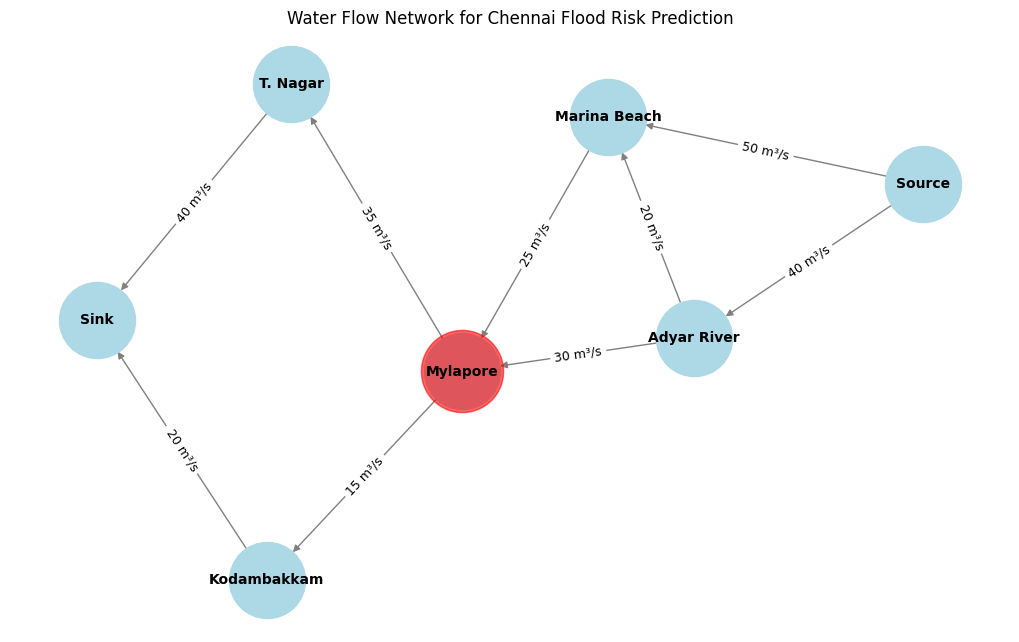

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with capacities (Water Flow Capacity in m³/s)
edges = [
    ("Source", "Marina Beach", 50),
    ("Source", "Adyar River", 40),
    ("Adyar River", "Marina Beach", 20),
    ("Adyar River", "Mylapore", 30),
    ("Marina Beach", "Mylapore", 25),
    ("Mylapore", "T. Nagar", 35),
    ("Mylapore", "Kodambakkam", 15),
    ("T. Nagar", "Sink", 40),
    ("Kodambakkam", "Sink", 20)
]

# Add edges to graph
for u, v, cap in edges:
    G.add_edge(u, v, capacity=cap)

# Compute Max Flow
flow_value, flow_dict = nx.maximum_flow(G, "Source", "Sink")

# Print Maximum Flow Results
print("\n🔹 Maximum Water Flow Capacity:", flow_value)
print("\n🔹 Flow Distribution Across Regions:")
for u, flows in flow_dict.items():
    for v, f in flows.items():
        if f > 0:
            print(f"   {u} → {v}: {f} m³/s")

# Define drainage capacity threshold for flood risk assessment
drainage_capacity = {
    "Marina Beach": 40,
    "Adyar River": 35,
    "Mylapore": 30,
    "T. Nagar": 45,
    "Kodambakkam": 20
}

# Identify flood-prone areas
flood_risk_areas = []
for node, capacity in drainage_capacity.items():
    total_inflow = sum(flow_dict[prev][node] for prev in G.predecessors(node))
    if total_inflow > capacity:
        flood_risk_areas.append(node)

# Print Flood-Prone Areas
print("\n🔹 High Flood Risk Areas (Exceeding Drainage Capacity):")
if flood_risk_areas:
    for area in flood_risk_areas:
        print(f"   ⚠ {area} (Risk Level: HIGH)")
else:
    print("   ✅ No areas exceed drainage capacity.")

# Compute Betweenness Centrality (Critical Zone Detection)
centrality = nx.betweenness_centrality(G, weight="capacity")

# Identify Critical Zones (High Centrality)
critical_zones = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]

print("\n🔹 Critical Water Flow Zones (High Betweenness Centrality):")
for node, value in critical_zones:
    print(f"   🌊 {node}: {round(value, 3)}")

# Visualizing the Graph with Risk Areas Highlighted
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Positioning the nodes

# Draw the main network
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10, font_weight="bold")

# Highlight flood-prone areas in red
nx.draw_networkx_nodes(G, pos, nodelist=flood_risk_areas, node_color="red", node_size=3500, alpha=0.6)

# Draw edge labels (capacity values)
edge_labels = {(u, v): f"{d['capacity']} m³/s" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Water Flow Network for Chennai Flood Risk Prediction")
plt.show()


🌪️ Shortest Storm Path Prediction:
   Bay of Bengal: 0 (relative travel time)
   Marina Beach: 10 (relative travel time)
   Mylapore: 20 (relative travel time)
   T. Nagar: 28 (relative travel time)
   Kodambakkam: 40 (relative travel time)


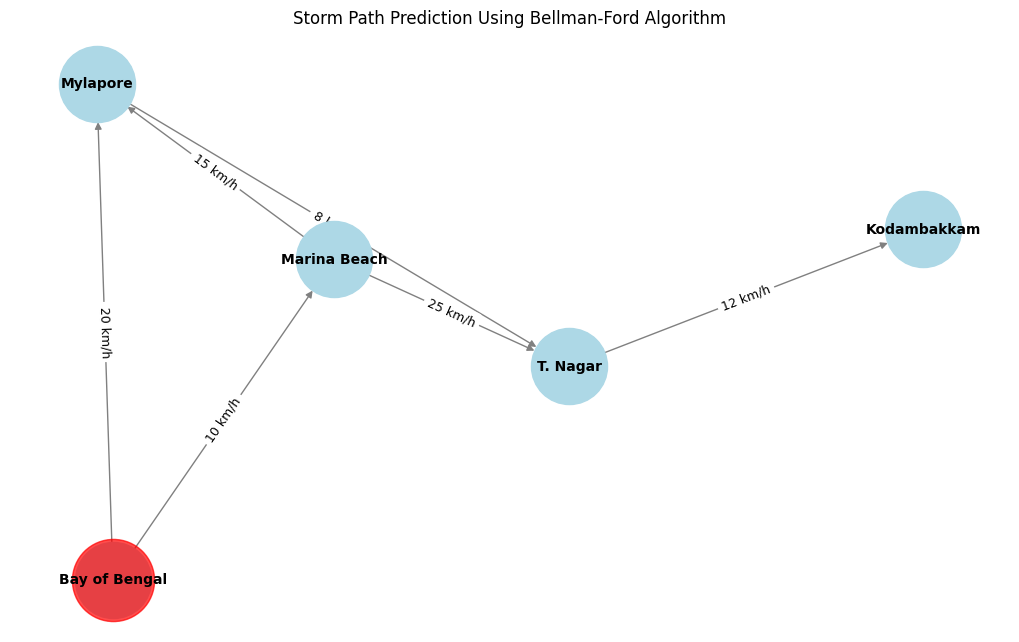

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class StormGraph:
    def __init__(self, locations):
        self.graph = []
        self.locations = locations  # Dictionary mapping index to location name
        self.V = len(locations)

    def add_edge(self, u, v, wind_speed):
        """ Add storm movement edge with wind speed as weight """
        self.graph.append((u, v, wind_speed))

    def bellman_ford(self, src):
        """ Compute shortest storm path from source location """
        dist = {i: float("inf") for i in range(self.V)}
        dist[src] = 0  # Source starts at 0

        # Relax all edges |V| - 1 times
        for _ in range(self.V - 1):
            for u, v, w in self.graph:
                if dist[u] != float("inf") and dist[u] + w < dist[v]:
                    dist[v] = dist[u] + w

        # Convert results to location names
        return {self.locations[i]: dist[i] for i in range(self.V)}

# Define locations
locations = {0: "Bay of Bengal", 1: "Marina Beach", 2: "Mylapore", 3: "T. Nagar", 4: "Kodambakkam"}

# Create graph
storm = StormGraph(locations)

# Add edges (Wind paths with speeds as weights)
storm.add_edge(0, 1, 10)  # Bay of Bengal → Marina Beach
storm.add_edge(1, 2, 15)  # Marina Beach → Mylapore
storm.add_edge(2, 3, 8)   # Mylapore → T. Nagar
storm.add_edge(3, 4, 12)  # T. Nagar → Kodambakkam
storm.add_edge(0, 2, 20)  # Direct Bay of Bengal → Mylapore
storm.add_edge(1, 3, 25)  # Direct Marina Beach → T. Nagar

# Predict storm path
storm_path = storm.bellman_ford(0)

# Print Storm Tracking Results
print("\n🌪️ Shortest Storm Path Prediction:")
for loc, time in storm_path.items():
    print(f"   {loc}: {time} (relative travel time)")

# Create a graph for visualization
G = nx.DiGraph()
for u, v, w in storm.graph:
    G.add_edge(locations[u], locations[v], weight=w)

# Position nodes using a layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes & edges
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10, font_weight="bold")

# Highlight storm start point
nx.draw_networkx_nodes(G, pos, nodelist=["Bay of Bengal"], node_color="red", node_size=3500, alpha=0.7)

# Draw edge labels (wind speeds)
edge_labels = {(u, v): f"{d['weight']} km/h" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Storm Path Prediction Using Bellman-Ford Algorithm")
plt.show()